# Goal

* A basic, full run of the SIPSim pipeline with the whole bacterial genome dataset to see:
  * Does it work?
  * Does the output as each stage look OK?

# Setting variables

In [25]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/validation/'
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/'

# Init

In [26]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image

In [27]:
import os
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [29]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

# Simulating fragments

In [30]:
!cd $workDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

CPU times: user 4.48 s, sys: 498 ms, total: 4.98 s
Wall time: 25min 58s


## Number of amplicons per taxon

In [43]:
!cd $workDir; \
    grep "Number of amplicons: " ampFrags.log | \
    perl -pe 's/.+ +//' | hist


 424|   o        
 402|   o        
 380|   o        
 358|   o        
 335|   o        
 313|   o        
 291|   o        
 269|   o        
 246|   o        
 224|   o        
 202|   o        
 180|  oo o      
 157|  oooo      
 135|  oooo      
 113|  oooo      
  91|  oooo      
  68|  ooooo     
  46| ooooooo    
  24| ooooooo    
   2| ooooooooooo
     -----------

------------------------------
|          Summary           |
------------------------------
|     observations: 1210     |
|    min value: 0.000000     |
|      mean : 3.646281       |
|    max value: 16.000000    |
------------------------------


# Converting fragments to kde object

In [45]:
!cd $workDir; \
    SIPSim fragment_KDE \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Checking ampfrag info

In [46]:
!cd $workDir; \
    SIPSim KDE_info -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt

Loading KDEs...


In [65]:
%%R -i workDir -w 600 -h 300

# loading
inFile = file.path(workDir, 'ampFrags_kde_info.txt')
df = read.delim(inFile, sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

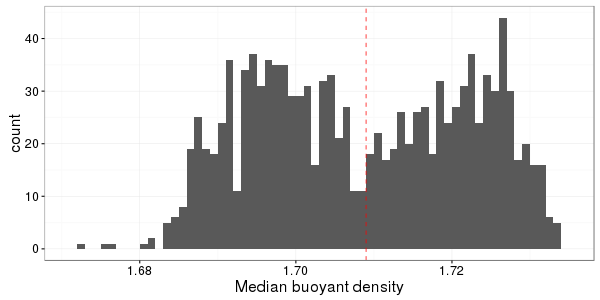

In [70]:
%%R -w 600 -h 300
# plotting
p.amp = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.amp

## check of metagenome fragment GC 

* GC of amplicon fragments should be much more bi-modal

In [60]:
!cd $workDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    > shotFrags.pkl \
    2> shotFrags.log

In [61]:
!cd $workDir; \
    SIPSim fragment_KDE \
    shotFrags.pkl \
    > shotFrags_kde.pkl

In [62]:
!cd $workDir; \
    SIPSim KDE_info -s shotFrags_kde.pkl \
    > shotFrags_kde_info.txt

Loading KDEs...


In [67]:
%%R -i workDir -w 600 -h 300

# loading
inFile = file.path(workDir, 'shotFrags_kde_info.txt')
df = read.delim(inFile, sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

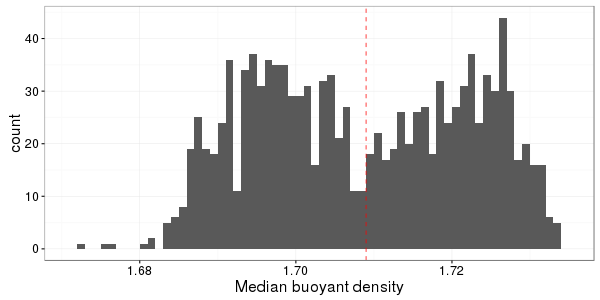

In [71]:
%%R -w 600 -h 300
# plotting
p.shot = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.shot

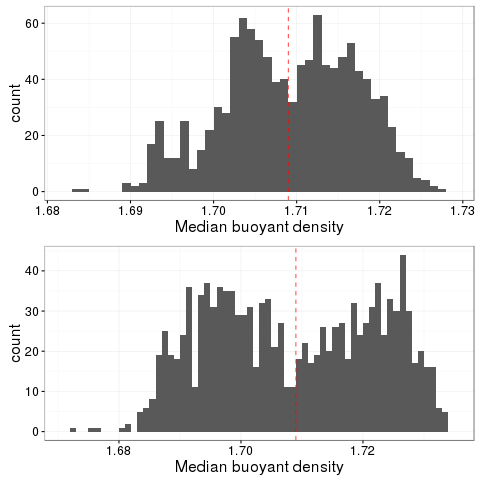

In [69]:
%%R
grid.arrange(p.amp, p.shot, ncol=1)

## NOTE:

* as expected, shotgun fragments are more bin-modal and deviating from 50% GC

# Adding diffusion

In [73]:
!cd $workDir; \
    SIPSim diffusion \
    ampFrags_kde.pkl \
    --np 24 \
    > ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif.log

# Adding DBL 'contamination'

* DBL = diffusive boundary layer

In [378]:
!cd $workDir; \
    SIPSim DBL \
    ampFrags_kde_dif.pkl \
    --np 24 \
    > ampFrags_kde_dif_DBL.pkl \
    2> ampFrags_kde_dif_DBL.log
    
# checking output    
!cd $workDir; \
    tail ampFrags_kde_dif_DBL.log

Processing: Ruminococcus_albus_7_DSM_20455
Processing: Candidatus_Solibacter_usitatus_Ellin6076
Processing: Acidimicrobium_ferrooxidans_DSM_10331
Processing: Candidatus_Chloracidobacterium_thermophilum_B
Processing: Streptococcus_macedonicus_ACA-DC_198
Processing: Hyphomonas_neptunium_ATCC_15444
Processing: Adlercreutzia_equolifaciens_DSM_19450
Processing: Pelobacter_carbinolicus_DSM_2380
Processing: Nocardia_farcinica_IFM_10152
Processing: Dyadobacter_fermentans_DSM_18053


## Comparing DBL+diffusion to diffusion

In [400]:
# none
!cd $workDir; \
    SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt
    
# diffusion
!cd $workDir; \
    SIPSim KDE_info \
    -s ampFrags_kde_dif.pkl \
    > ampFrags_kde_dif_info.txt
    
# diffusion + DBL    
!cd $workDir; \
    SIPSim KDE_info \
    -s ampFrags_kde_dif_DBL.pkl \
    > ampFrags_kde_dif_DBL_info.txt

Loading KDEs...
Loading KDEs...
Loading KDEs...


In [405]:
%%R -i workDir

inFile = file.path(workDir, 'ampFrags_kde_info.txt')
df.raw = read.delim(inFile, sep='\t')
df.raw$stage = 'raw'

inFile = file.path(workDir, 'ampFrags_kde_dif_info.txt')
df.dif = read.delim(inFile, sep='\t')
df.dif$stage = 'diffusion'
inFile = file.path(workDir, 'ampFrags_kde_dif_DBL_info.txt')
df.DBL = read.delim(inFile, sep='\t')
df.DBL$stage = 'diffusion +\nDBL'

df = rbind(df.raw, df.dif, df.DBL)
df.dif = ''
df.DBL = ''
df %>% head(n=3)

                     taxon_ID KDE_ID        min percentile_5 percentile_25
1  Vibrio_vulnificus_MO6-24_O      1   1.703211     1.704749      1.706597
2  Vibrio_vulnificus_MO6-24_O      2 451.000000  4094.950000   6111.750000
3 Caldisericum_exile_AZM16c01    NaN        NaN          NaN           NaN
         mean      median percentile_75 percentile_95         max        stdev
1    1.707351    1.707388      1.708165      1.709475     1.71362 1.338108e-03
2 7031.729100 7286.500000   8209.250000   9074.050000 10296.00000 1.549401e+03
3         NaN         NaN           NaN           NaN         NaN          NaN
  stage
1   raw
2   raw
3   raw


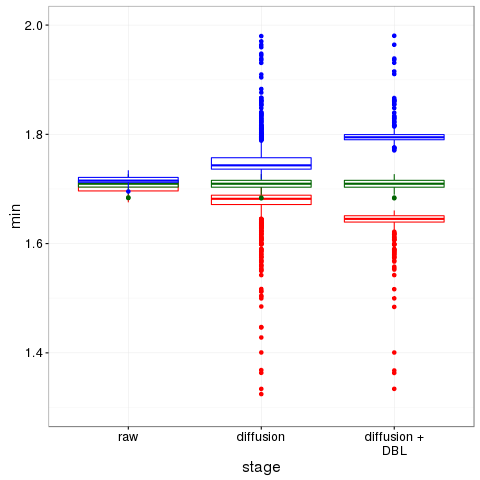

In [406]:
%%R

df$stage = factor(df$stage, levels=c('raw', 'diffusion', 'diffusion +\nDBL'))

ggplot(df, aes(stage)) +
    geom_boxplot(aes(y=min), color='red') +
    geom_boxplot(aes(y=median), color='darkgreen') +
    geom_boxplot(aes(y=max), color='blue') +
    scale_y_continuous(limits=c(1.3, 2)) +
    labs(y = 'Buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

# Creating a community file

In [407]:
!cd $workDir; \
    SIPSim communities \
    $genomeDir/genome_index.txt \
    --n_comm 2 \
    > comm.txt

## Plotting community rank abundances

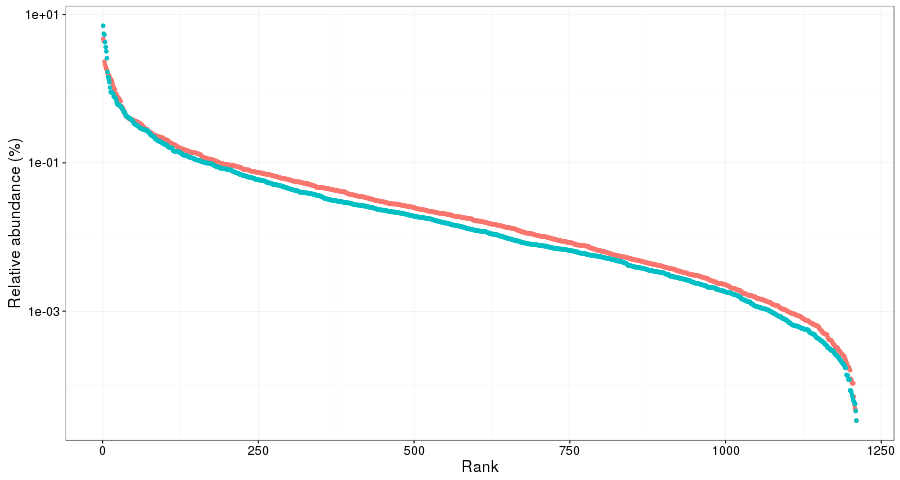

In [408]:
%%R -w 900 -i workDir

setwd(workDir)

tbl = read.delim('comm.txt', sep='\t')

tbl$library = as.character(tbl$library)

ggplot(tbl, aes(rank, rel_abund_perc, color=library, group=taxon_name)) +
    geom_point() +
    scale_y_log10() +
    labs(x='Rank', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        legend.position='none'
        )

#### Notes:

* Colors = pre-fractionation communities

# Making an incorp config file

In [412]:
!cd $workDir; \
    SIPSim incorpConfigExample \
    --percTaxa 10 \
    --percIncorpUnif 100 \
    > PT10_PI100.config
    
# checking output
!cd $workDir; \
    head PT10_PI100.config


[1]
    # baseline: no incorporation
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            
            [[[[interPopDist 1]]]]


# Adding isotope incorporation to BD distribution

In [543]:
!cd $workDir; \
    SIPSim isotope_incorp \
    ampFrags_kde_dif_DBL.pkl \
    PT10_PI100.config \
    --comm comm.txt \
    --np 24 \
    > ampFrags_kde_dif_DBL_incorp.pkl \
    2> ampFrags_kde_dif_DBL_incorp.log
    
# checking lag
!cd $workDir; \
    tail ampFrags_kde_dif_DBL_incorp.log

Processing: Cronobacter_sakazakii_SP291
Processing: Starkeya_novella_DSM_506
Processing: Treponema_denticola_ATCC_35405
Processing: Streptomyces_bingchenggensis_BCW-1
Processing: Bifidobacterium_bifidum_BGN4
Processing: Anaplasma_centrale_str_Israel
Processing: Brucella_suis_bv_1_str_S2
Processing: Streptococcus_agalactiae_COH1
Processing: Brevibacillus_brevis_NBRC_100599
Processing: Halorhodospira_halophila_SL1


# Calculating BD shift from isotope incorporation

In [544]:
!cd $workDir; \
    SIPSim BD_shift \
    ampFrags_kde_dif_DBL.pkl \
    ampFrags_kde_dif_DBL_incorp.pkl \
    --np 30 \
    > ampFrags_kde_dif_DBL_incorp_BD-shift.txt \
    2> ampFrags_kde_dif_DBL_incorp_BD-shift.log
    
# checking log
!cd $workDir; \
    tail ampFrags_kde_dif_DBL_incorp_BD-shift.log

  Processing: Leptospirillum_ferriphilum_YSK
  Processing: Blattabacterium_sp_Blattella_germanica_str_Bge
  Processing: Elizabethkingia_anophelis_NUHP1
  Processing: Thermosynechococcus_elongatus_BP-1
  Processing: Dyadobacter_fermentans_DSM_18053
  Processing: Bacteroides_thetaiotaomicron_VPI-5482
  Processing: Shigella_flexneri_Shi06HN006
  Processing: Dictyoglomus_thermophilum_H-6-12
  Processing: Ureaplasma_urealyticum_serovar_10_str_ATCC_33699
  Processing: Lactobacillus_rhamnosus_Lc_705


## Plotting BD-shift

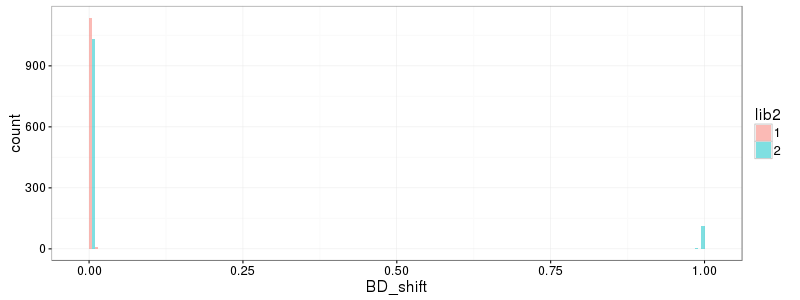

In [545]:
%%R -i workDir -w 800 -h 300

inFile = file.path(workDir, 'ampFrags_kde_dif_DBL_incorp_BD-shift.txt')

tbl = read.csv(inFile, sep='\t')

tbl$lib2 = as.character(tbl$lib2)
ggplot(tbl, aes(BD_shift, fill=lib2)) +
    geom_histogram(position='dodge', alpha=0.5, binwidth=0.01) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

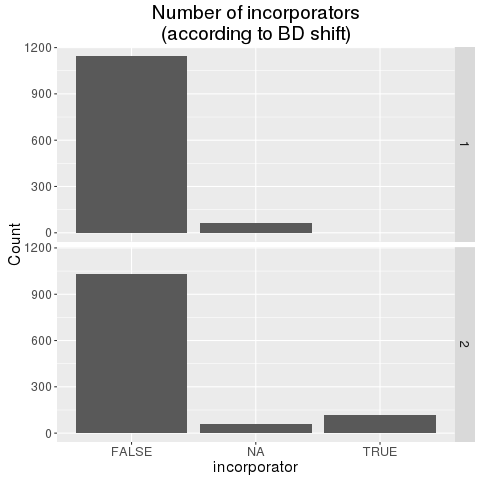

In [546]:
%%R

tbl.s = tbl %>% 
    mutate(incorporator = ifelse(BD_shift > 0.05, TRUE, FALSE)) %>%
    mutate(incorporator = ifelse(is.na(incorporator), 'NA', incorporator)) %>%
    group_by(lib2, incorporator) %>%
    summarize(n_incorps = n())

ggplot(tbl.s, aes(incorporator, n_incorps)) +
    geom_bar(stat='identity') +
    labs(y = 'Count', title='Number of incorporators\n(according to BD shift)') +
    facet_grid(lib2 ~ .) +
    theme(
        text = element_text(size=16)
    )

# Simulating gradient fractions

In [547]:
!cd $workDir; \
    SIPSim gradient_fractions \
    comm.txt \
    > fracs.txt    

## Plotting fractions

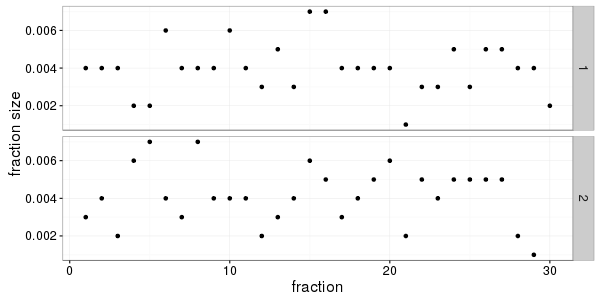

In [548]:
%%R -i workDir -w 600 -h 300
setwd(workDir)

tbl = read.delim('fracs.txt', sep='\t')

ggplot(tbl, aes(fraction, fraction_size)) +
    geom_point() +
    facet_grid(library ~ .) +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

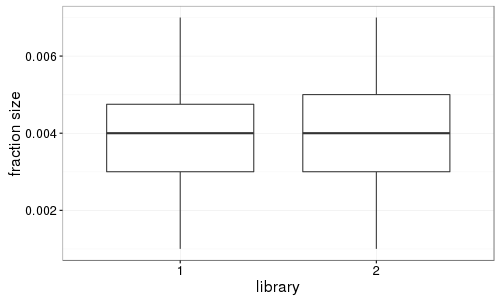

In [549]:
%%R -w 500 -h 300
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating an OTU table

In [550]:
!cd $workDir; \
    SIPSim OTU_table \
    ampFrags_kde_dif_DBL_incorp.pkl \
    comm.txt \
    fracs.txt \
    --abs 1e9 \
    --np 24 \
    > OTU_n2_abs1e9.txt \
    2> OTU_n2_abs1e9.log 
    
# checking log
!cd $workDir; \
    tail OTU_n2_abs1e9.log 

  Processing taxon: "Marinobacter_adhaerens_HP15"
   taxon abs-abundance:  14370988
  Processing taxon: "Shewanella_violacea_DSS12"
   taxon abs-abundance:  13452571
  Processing taxon: "Bacillus_cellulosilyticus_DSM_2522"
   taxon abs-abundance:  12207073
  Processing taxon: "Rhodospirillum_photometricum_DSM_122"
   taxon abs-abundance:  10390014
  Processing taxon: "Oscillatoria_acuminata_PCC_6304"
   taxon abs-abundance:  9044187


## Plotting taxon abundances

In [551]:
%%R -i workDir

inFile = file.path(workDir, 'OTU_n2_abs1e9.txt')

# loading file
df = read.delim(inFile, sep='\t')

In [552]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

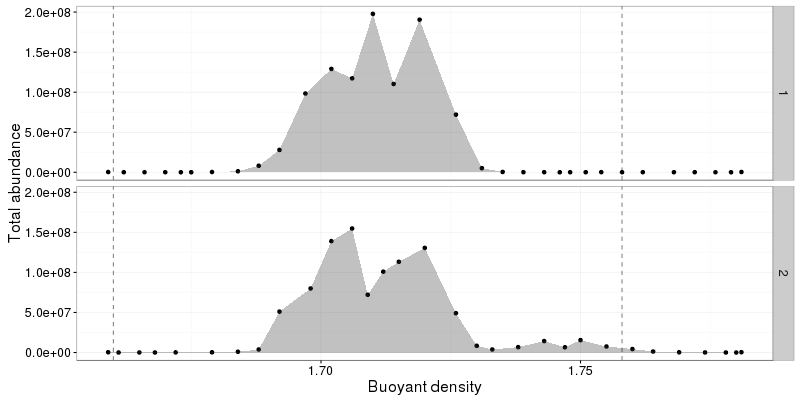

In [553]:
%%R -w 800 -h 400
# plotting absolute abundances

df.s = df %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count))

## plot
p = ggplot(df.s, aes(BD_mid, total_count)) +
    geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Total abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

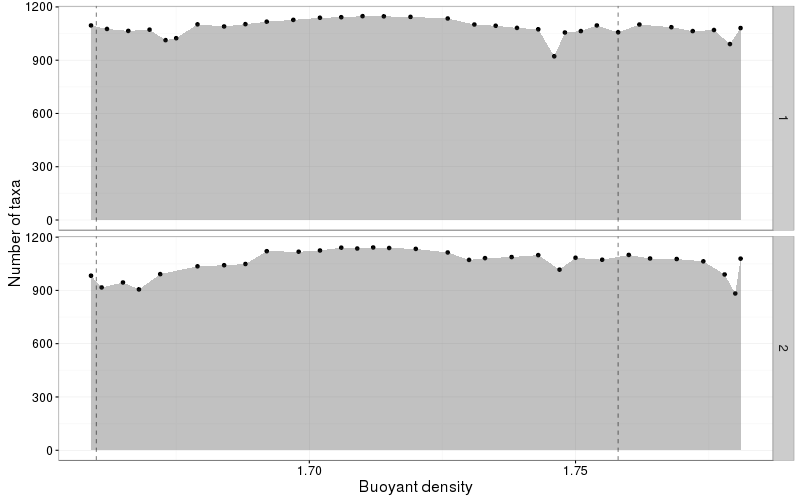

In [554]:
%%R -w 800 -h 500
# plotting number of taxa at each BD

df.nt = df %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.nt, aes(BD_mid, n_taxa)) +
    geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

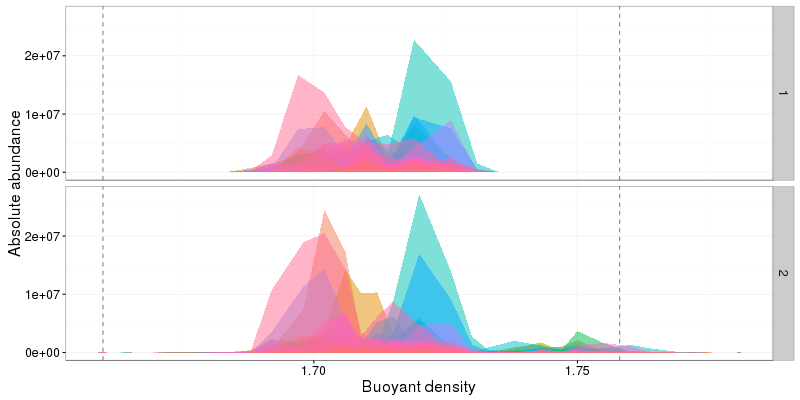

In [555]:
%%R -w 800 -h 400
# plotting relative abundances

## plot
p = ggplot(df, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Absolute abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

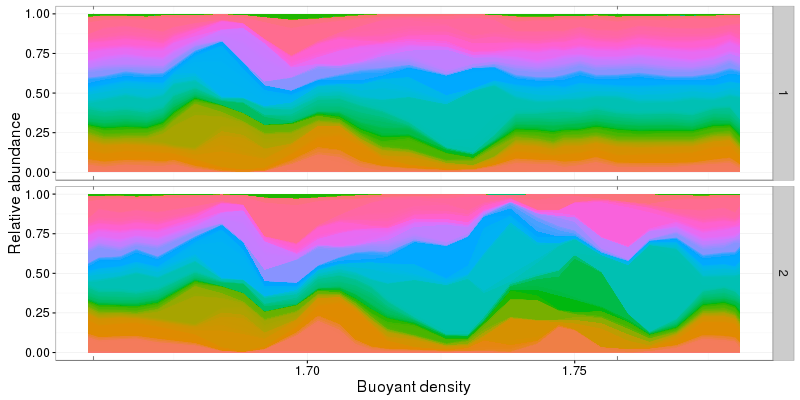

In [556]:
%%R -w 800 -h 400
p + 
    geom_area(stat='identity', position='fill') +
    labs(x='Buoyant density', y='Relative abundance')

## Plotting shannon diversity

In [557]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>%
        select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

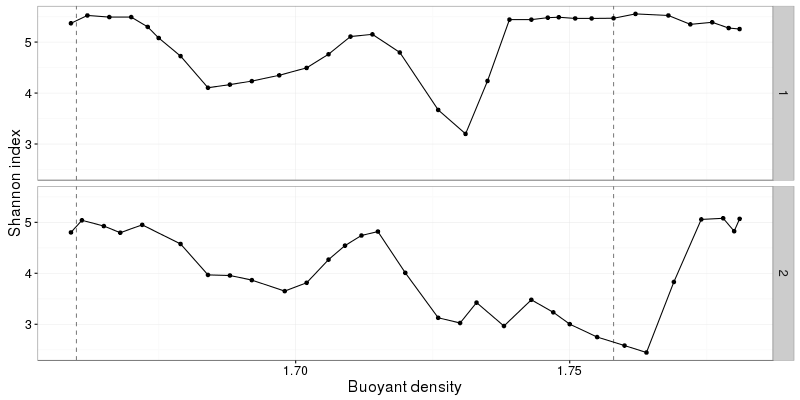

In [558]:
%%R -w 800 -h 400

# calculating shannon
df.shan = shannon_index_long(df, 'count', 'library', 'fraction')

## plot
p = ggplot(df.shan, aes(BD_mid, shannon)) +
    geom_point() +
    geom_line() +
    #geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Shannon index') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

## OTU BD range

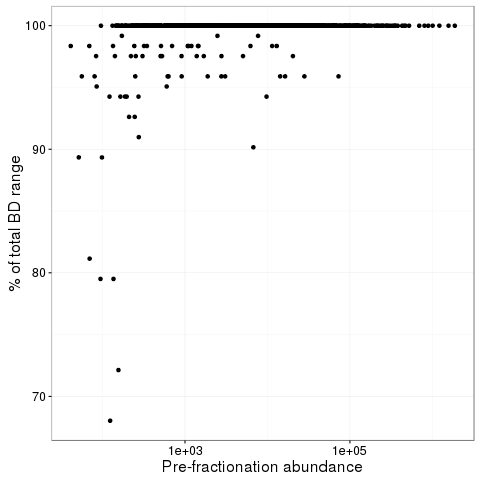

In [559]:
%%R

max_BD_range = max(df$BD_mid) - min(df$BD_mid)

df.r = df %>%
    filter(count > 0) %>%
    group_by(taxon) %>%
    summarize(mean_count = mean(count),
              min_BD = min(BD_mid),
              max_BD = max(BD_mid),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() 

# plotting
ggplot(df.r, aes(mean_count, BD_range_perc, group=taxon)) +
    geom_point() +
    scale_x_log10() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    #geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )
    

# Subsampling from the OTU table 

* simulating sequencing of the DNA pool

In [560]:
!cd $workDir; \
    SIPSim OTU_subsample \
    --dist normal \
    --dist_params loc:30000,scale:5000 \
    OTU_n2_abs1e9.txt \
    > OTU_n2_abs1e9_subNorm.txt

### Plotting seq count distribution

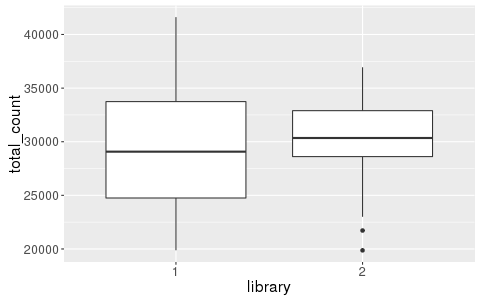

In [561]:
%%R -h 300
setwd(workDir)

df = read.csv('OTU_n2_abs1e9_subNorm.txt', sep='\t')

df.s = df %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(df.s, aes(library, total_count)) +
    geom_boxplot() +
    theme(
        text = element_text(size=16)
    )

# Plotting abundance distributions (paper figure)

In [562]:
%%R -i workDir

setwd(workDir)

# loading file
df.abs = read.delim('OTU_n2_abs1e9.txt', sep='\t')
df.sub = read.delim('OTU_n2_abs1e9_subNorm.txt', sep='\t')

lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.abs = mutate(df.abs, library = plyr::revalue(as.character(library), lib.reval))
df.sub = mutate(df.sub, library = plyr::revalue(as.character(library), lib.reval))

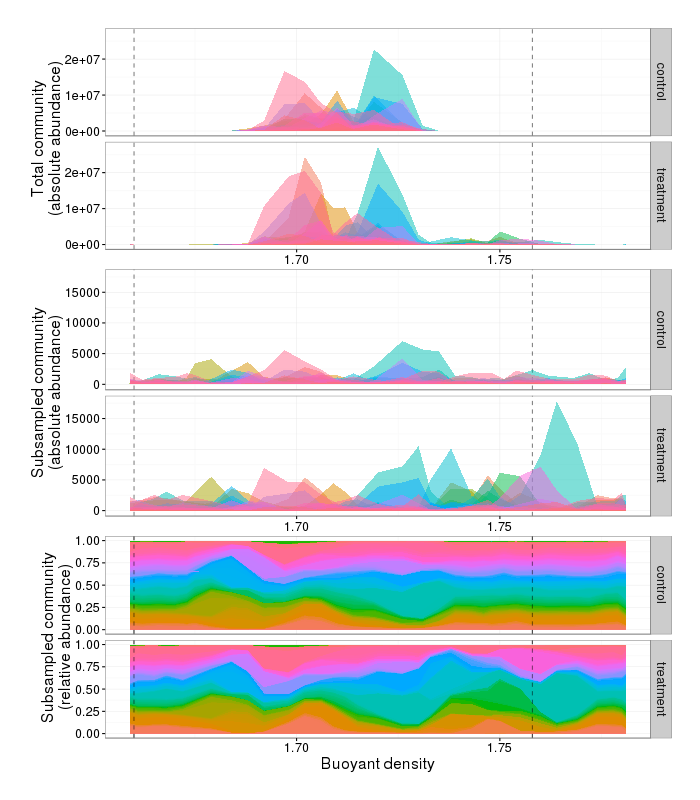

In [563]:
%%R -w 700 -h 800
# plotting absolute abundances
## plot
p = ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank(),
        legend.position = 'none',
        plot.margin=unit(c(1,1,0.1,1), "cm")
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Total community\n(absolute abundance)')

# plotting absolute abundances of subsampled
## plot
p = ggplot(df.sub, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Subsampled community\n(absolute abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )

# plotting relative abundances of subsampled
p3 = p + geom_area(stat='identity', position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(y='Subsampled community\n(relative abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),
          plot.margin=unit(c(0.1,1,1,1.35), "cm")
        )

# combining plots
grid.arrange(p1, p2, p3, ncol=1)

In [564]:
%%R -i figureDir 
# saving figure

outFile = paste(c(figureDir, 'abundDist_example.pdf'), collapse='/')

pdf(outFile, width=10.5, height=12)
grid.arrange(p1, p2, p3, ncol=1)
dev.off()

png 
  2 


# Making a wide OTU table

In [565]:
!cd $workDir; \
    SIPSim OTU_wideLong -w \
    OTU_n2_abs1e9_subNorm.txt \
    > OTU_n2_abs1e9_subNorm_w.txt

# Making metadata (phyloseq: sample_data)

In [566]:
!cd $workDir; \
    SIPSim OTU_sampleData \
    OTU_n2_abs1e9_subNorm.txt \
    > OTU_n2_abs1e9_subNorm_meta.txt

# Community analysis

## Phyloseq

In [567]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs1e9_subNorm_w.txt \
    -s OTU_n2_abs1e9_subNorm_meta.txt \
    > OTU_n2_abs1e9_subNorm.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e9_subNorm.physeq \
    OTU_n2_abs1e9_subNorm_bray-NMDS.pdf    
## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    OTU_n2_abs1e9_subNorm.physeq \
    --BD_min 1.71 --BD_max 1.75 --occur 0.25 \
    > OTU_n2_abs1e9_subNorm_filt.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e9_subNorm_filt.physeq \
    OTU_n2_abs1e9_subNorm_filt_bray-NMDS.pdf
    
convert OTU_n2_abs1e9_subNorm_bray-NMDS.pdf OTU_n2_abs1e9_subNorm_bray-NMDS.png
convert OTU_n2_abs1e9_subNorm_filt_bray-NMDS.pdf OTU_n2_abs1e9_subNorm_filt_bray-NMDS.png

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1167613 
Run 1 stress 0.1620547 
Run 2 stress 0.13671 
Run 3 stress 0.1649659 
Run 4 stress 0.1857439 
Run 5 stress 0.1501013 
Run 6 stress 0.174179 
Run 7 stress 0.1167613 
... procrustes: rmse 4.943504e-05  max resid 0.0002153163 
*** Solution reached
Square root transformation
Wisconsin double standardization
Run 0 stress 0.05564127 
Run 1 stress 0.05564142 
... procrustes: rmse 6.824412e-05  max resid 0.000210131 
*** Solution reached


Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 


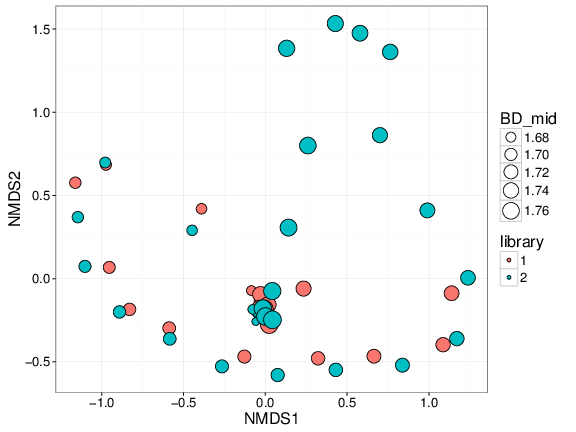

In [568]:
os.chdir(workDir)
Image(filename='OTU_n2_abs1e9_subNorm_bray-NMDS.png') 

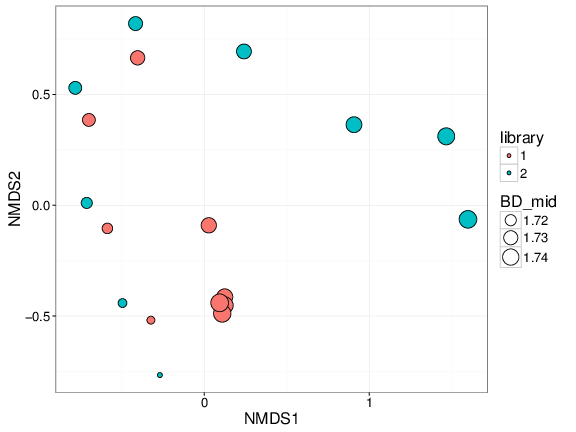

In [569]:
os.chdir(workDir)
Image(filename='OTU_n2_abs1e9_subNorm_filt_bray-NMDS.png')

## DESeq2

In [590]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# Chuck's method

## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs1e9_subNorm_filt.physeq \
    --log2 0.25 \
    > OTU_n2_abs1e9_subNorm_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_DBL_incorp_BD-shift.txt \
    OTU_n2_abs1e9_subNorm_DESeq2 \
    --padjBH 0.1

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
converting counts to integer mode
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 53 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message:
replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx_data.csv
File written: DESeq2-cMtx
File written: DESeq2-cMtx_table.csv
File written: DESeq2-cMtx_overall.csv
File written: DESeq2-cMtx_byClass

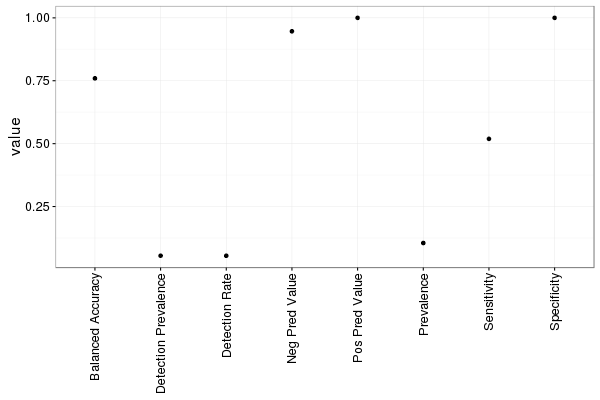

In [591]:
%%R -i workDir -w 600 -h 400

setwd(workDir)

byClass = read.csv('DESeq2-cMtx_byClass.csv')

ggplot(byClass, aes(X, byClass)) +
    geom_point() +
    labs(y='value') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )

In [592]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# altHypothesis = 'greater'

## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs1e9_subNorm_filt.physeq \
    --log2 0.25 \
    --hypo greater \
    > OTU_n2_abs1e9_subNorm_DESeq2
    
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_DBL_incorp_BD-shift.txt \
    OTU_n2_abs1e9_subNorm_DESeq2 \
    --padj 0.1    

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
converting counts to integer mode
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 53 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message:
replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx_data.csv
File written: DESeq2-cMtx
File written: DESeq2-cMtx_table.csv
File written: DESeq2-cMtx_overall.csv
File written: DESeq2-cMtx_byClass

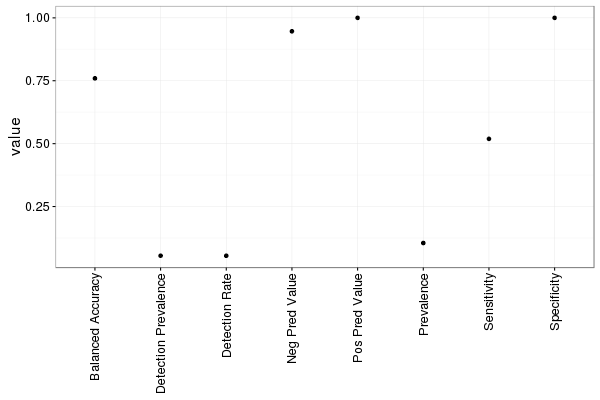

In [593]:
%%R -i workDir -w 600 -h 400

setwd(workDir)

byClass = read.csv('DESeq2-cMtx_byClass.csv')

ggplot(byClass, aes(X, byClass)) +
    geom_point() +
    labs(y='value') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )

# Conclusions


* BD_shift and OTU_table are memory intensive & must use less cores
* DESeq2 sensitivity is low, but specificity is perfect

## Plotting results of DESeq2

In [594]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

In [595]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

df = read.csv('DESeq2-cMtx_data.csv')

df = df %>%
    filter(! is.na(log2FoldChange)) %>%
    mutate(taxon = reorder(taxon, -log2FoldChange),
           cls = mapply(clsfy, incorp.pred, incorp.known))

df %>% head(n=3)

  lib1 lib2                              taxon  BD_shift   baseMean
1   NA    2         Vibrio_vulnificus_MO6-24_O 0.9964687 206.391201
2   NA    2        Spiroplasma_taiwanense_CT-1 0.0000000   3.373211
3   NA    2 Thermoanaerobacter_wiegelii_Rt8_B1 0.0000000   1.493209
  log2FoldChange    lfcSE     stat       pvalue        padj            p
1       5.107336 1.387323 3.501228 0.0002315594 0.005204824 0.0002315594
2      -4.102573 1.206735 0.000000 0.9998450610 0.999997833 0.9998450610
3      -2.526034 1.016399 0.000000 0.9968452322 0.999997833 0.9968452322
      padj.BH incorp.known incorp.pred           cls
1 0.005204824         TRUE        TRUE True positive
2 0.999997833        FALSE       FALSE True negative
3 0.999997833        FALSE       FALSE True negative


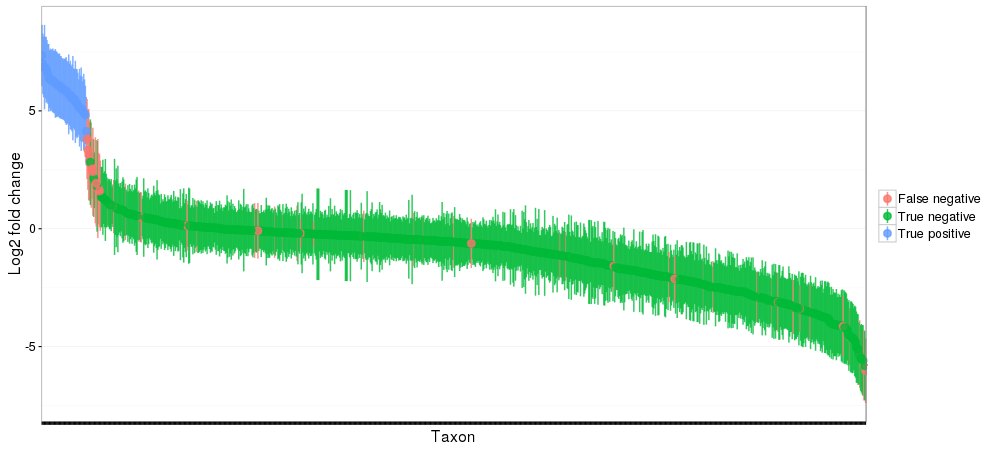

In [596]:
%%R -w 1000 -h 450

ggplot(df, aes(taxon, log2FoldChange, color=cls, ymin=log2FoldChange - lfcSE, ymax=log2FoldChange + lfcSE)) +
    geom_pointrange(size=0.7, alpha=0.8) +
    labs(x = 'Taxon', y = 'Log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),        
        legend.title=element_blank(),
        axis.text.x = element_blank()
        )

In [597]:
%%R -i figureDir

outFile = paste(c(figureDir, 'l2fc_example.pdf'), collapse='/')
ggsave(outFile, width=10, height=4.5)

__Notes:__

* Red circles = true positives

* False positives should increase with taxon GC 
  * Higher GC moves 100% incorporators too far to the right the gradient for the 'heavy' BD range of 1.71-1.75

# Plotting abundance distribution of True Positive taxa (actual incorporators) 

In [635]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

df.ds = read.csv('DESeq2-cMtx_data.csv')

# loading file
#df.otu = read.delim('OTU_n2_abs1e9_subNorm.txt', sep='\t')
df.otu = read.delim('OTU_n2_abs1e9.txt', sep='\t')

df.j = inner_join(df.otu, df.ds, c('taxon' = 'taxon'))

# edit
lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.j = mutate(df.j, library = plyr::revalue(as.character(library), lib.reval))

df.j %>% head(n=3)

  library                          taxon    fraction BD_min BD_mid BD_max count
1 control Acaryochloris_marina_MBIC11017  -inf-1.660   -Inf  1.659  1.659    63
2 control Acaryochloris_marina_MBIC11017 1.660-1.664  1.660  1.662  1.664    11
3 control Acaryochloris_marina_MBIC11017 1.664-1.668  1.664  1.666  1.668    10
     rel_abund lib1 lib2 BD_shift  baseMean log2FoldChange    lfcSE stat
1 1.707854e-04   NA    2        0 0.8540883      -1.832533 1.113067    0
2 8.683639e-05   NA    2        0 0.8540883      -1.832533 1.113067    0
3 7.707545e-05   NA    2        0 0.8540883      -1.832533 1.113067    0
     pvalue      padj         p   padj.BH incorp.known incorp.pred
1 0.9693266 0.9999978 0.9693266 0.9999978        FALSE       FALSE
2 0.9693266 0.9999978 0.9693266 0.9999978        FALSE       FALSE
3 0.9693266 0.9999978 0.9693266 0.9999978        FALSE       FALSE


In [636]:
%%R
# DESeq2 params
BD.win.min = 1.71
BD.win.max = 1.75

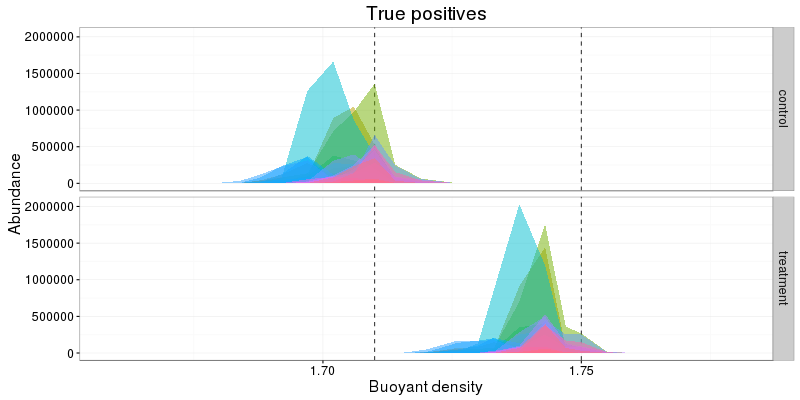

In [637]:
%%R -w 800 -h 400
# plotting absolute abundances

df.j.TP = df.j %>% 
    filter(incorp.known == TRUE & incorp.pred == TRUE) 


## plot
p = ggplot(df.j.TP, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Abundance', title='True positives') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p1

# Plotting abundance distribution of False Negative taxa (actual incorporators) 

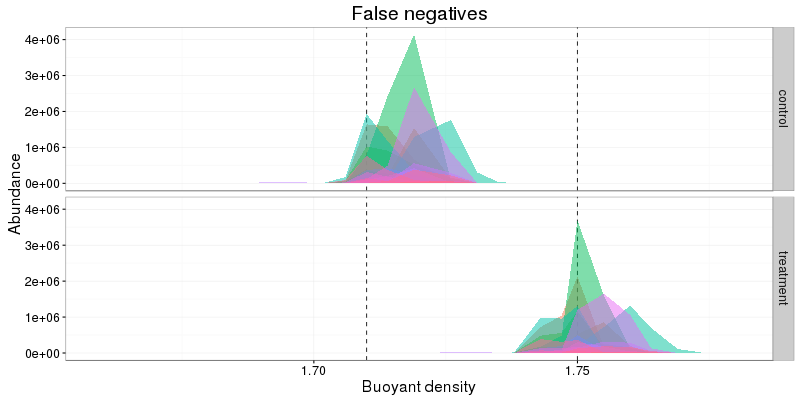

In [638]:
%%R -w 800 -h 400
# plotting relative abundances

df.j.FN = df.j %>% 
    filter(incorp.known == TRUE & incorp.pred == FALSE) 

## plot
p = ggplot(df.j.FN, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Abundance', title='False negatives') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p2

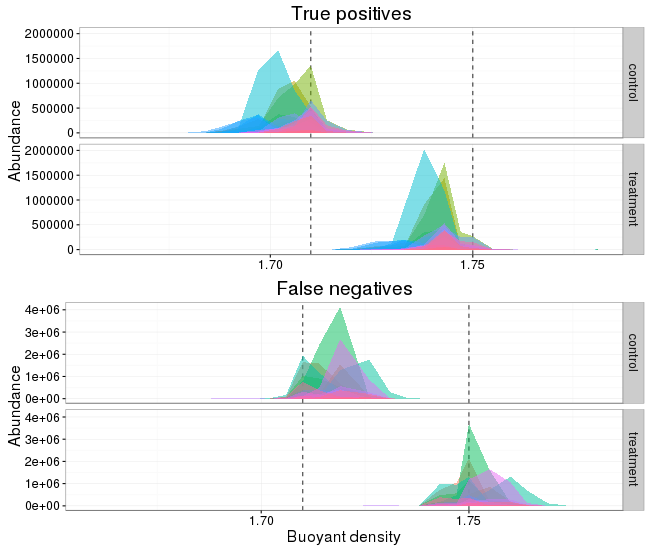

In [639]:
%%R -i figureDir -h 550 -w 650

outFile = paste(c(figureDir, 'abundDist_TP-FN_example.pdf'), collapse='/')

p1.e = p1 + theme(axis.title.x = element_blank())

pdf(outFile, width=13, height=11)
grid.arrange(p1.e, p2, ncol=1)
dev.off()

grid.arrange(p1.e, p2, ncol=1)

## Conclusions

* For 100% incorporation, the 'heavy' BD range of 1.71-1.75 does not encompass most of the incorporator abundance.
  * This results in negative log2fc

## Indy taxa BD shift plots

In [640]:
%%R
# checking on number of incorporators
df.j %>% filter(BD_shift > 0.05) %>% distinct(taxon) %>% nrow %>% print
df.j %>% filter(incorp.known == TRUE) %>% distinct(taxon) %>% nrow %>% print

[1] 104
[1] 104


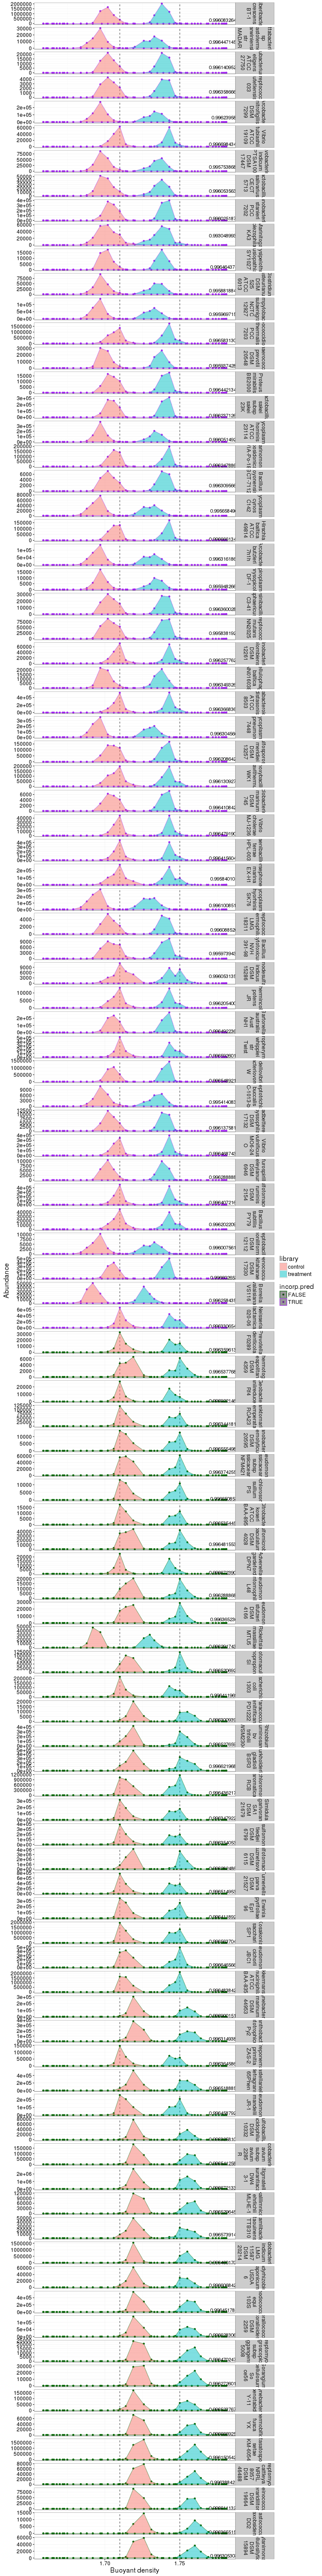

In [641]:
%%R -w 750 -h 6000
# plotting relative abundances

df.j.f = df.j %>%
    filter(incorp.known == TRUE) %>%
    mutate(taxon= gsub('_', '\n', taxon))
           
df.j.f$taxon = reorder(df.j.f$taxon, -df.j.f$log2FoldChange)

quant = function(x, p=0.95){
    x = x %>% as.numeric
    return(quantile(x, probs=c(0.9))[1] %>% as.numeric)
}

df.j.f.txt = df.j.f %>%
    group_by(taxon, BD_shift) %>%
    summarize(BD_mid = max(BD_mid),
              count = quant(count)) %>%
    ungroup() 


## plot
p = ggplot(df.j.f, aes(BD_mid, count)) +
    geom_point(aes(color=incorp.pred)) +
    geom_text(data=df.j.f.txt, aes(label=BD_shift)) +
    scale_color_manual(values=c('darkgreen', 'purple')) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Abundance') +
    facet_grid(taxon ~ ., scale='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    )

p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5, aes(fill=library, color=incorp.pred))
p2

# Enrichment of TP for abundant incorporators?

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [642]:
%%R -i workDir

setwd(workDir)

tbl.ds = read.csv('DESeq2-cMtx_data.csv')
tbl.otu = read.delim('OTU_n2_abs1e9.txt', sep='\t')

In [644]:
%%R
tbl.ds %>% filter(incorp.known==TRUE & incorp.pred==FALSE)

   lib1 lib2                                                  taxon  BD_shift
1    NA    2                         Xanthobacter_autotrophicus_Py2 0.9963149
2    NA    2                        Citrobacter_koseri_ATCC_BAA-895 0.9965354
3    NA    2                              Erwinia_pyrifoliae_Ep1_96 0.9964119
4    NA    2                     Corallococcus_coralloides_DSM_2259 0.9966283
5    NA    2                       Alkalilimnicola_ehrlichii_MLHE-1 0.9965296
6    NA    2                              Rickettsia_massiliae_MTU5 0.9962917
7    NA    2                  Deinococcus_peraridilitoris_DSM_19664 0.9966111
8    NA    2                            Turneriella_parva_DSM_21527 0.9965150
9    NA    2                           Geobacter_uraniireducens_Rf4 0.9969221
10   NA    2                        Bradyrhizobium_japonicum_USDA_6 0.9966068
11   NA    2                     Pelotomaculum_thermopropionicum_SI 0.9965207
12   NA    2                           Blastococcus_saxobsidens_

In [618]:
%%R
# OTU total counts
tbl.otu.sum = tbl.otu %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(count))
tbl.otu.sum %>% head(n=3)

Source: local data frame [3 x 3]
Groups: library [1]

  library                                taxon total_count
    (int)                               (fctr)       (int)
1       1       Acaryochloris_marina_MBIC11017      103591
2       1       Acetobacterium_woodii_DSM_1030      441168
3       1 Acetobacter_pasteurianus_IFO_3283-12        7973


In [654]:
%%R
# 
label.accuracy = function(known, pred){
    if(is.na(known) | is.na(pred)){
        return(NA)
        } else
    if(known==TRUE & pred==TRUE){
        return('TP')
        } else
    if(known==TRUE & pred==FALSE){
        return('FP')
        } else 
    if(known==FALSE & pred==TRUE){
        return('FN')
        } else {
    if(known==FALSE & pred==FALSE){
        return('TN')
        } else
        return(NA)
        }
    }

tbl.ds.acc = tbl.ds %>% 
    mutate(accuracy = mapply(label.accuracy, incorp.known, incorp.pred)) %>%
    filter(! is.na(accuracy))

tbl.ds.acc.j = inner_join(tbl.ds.acc, tbl.otu.sum, c('taxon' = 'taxon')) 
tbl.ds.acc.j %>% head(n=3)

  lib1 lib2                       taxon  BD_shift   baseMean log2FoldChange
1   NA    2  Vibrio_vulnificus_MO6-24_O 0.9964687 206.391201       5.107336
2   NA    2  Vibrio_vulnificus_MO6-24_O 0.9964687 206.391201       5.107336
3   NA    2 Spiroplasma_taiwanense_CT-1 0.0000000   3.373211      -4.102573
     lfcSE     stat       pvalue        padj            p     padj.BH
1 1.387323 3.501228 0.0002315594 0.005204824 0.0002315594 0.005204824
2 1.387323 3.501228 0.0002315594 0.005204824 0.0002315594 0.005204824
3 1.206735 0.000000 0.9998450610 0.999997833 0.9998450610 0.999997833
  incorp.known incorp.pred accuracy library total_count
1         TRUE        TRUE       TP       1      711045
2         TRUE        TRUE       TP       2      571003
3        FALSE       FALSE       TN       1     1139715


In [655]:
%%R
# how many TP & FN?
tbl.ds.acc.j %>% 
    group_by(library, accuracy) %>%
    summarize(n = n())

Source: local data frame [6 x 3]
Groups: library [?]

  library accuracy     n
    (int)    (chr) (int)
1       1       FP    50
2       1       TN   885
3       1       TP    54
4       2       FP    50
5       2       TN   885
6       2       TP    54


## Accuracy ~ Abundance 

In [652]:
%%R
library(ltm)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: MASS

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘MASS’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:dplyr’:

    select


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: msm

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: polycor

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robj

In [660]:
%%R

tbl.ds.acc.j %>%
    filter((accuracy == 'TP') | (accuracy == 'FP')) %>%
    group_by(lib2) %>%
    summarize(biserial_cor = biserial.cor(total_count, accuracy))

Source: local data frame [1 x 2]

   lib2 biserial_cor
  (int)        (dbl)
1     2    0.1320923


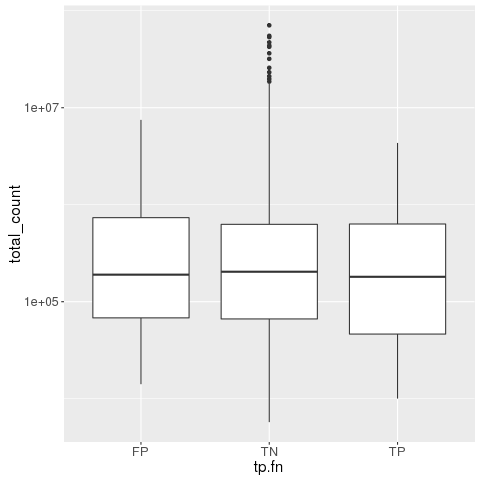

In [650]:
%%R

ggplot(tbl.tp.fn, aes(tp.fn, total_count)) +
    geom_boxplot() +
    scale_y_log10() +
    theme(
        text = element_text(size=16)
    )

***